# 모듈 임포트 및 데이터 로드

In [2]:
from tqdm.auto import tqdm
import random
import os

import torch
import pymysql

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import numpy as np
import pandas as pd

from datetime import datetime

In [3]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
import FinanceDataReader as fdr

In [6]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,73400,1,500,0.69,73000,73400,72800,8907632,650825104900,438182039170000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,138200,2,-1800,-1.29,140000,140800,138100,2309721,320762801100,100609926843000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,426000,1,4000,0.95,422000,428000,419000,195288,82907799000,99684000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,704000,1,3000,0.43,701000,705000,701000,39179,27541377000,50106496000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,58600,2,-400,-0.68,58800,59000,58500,977254,57310032600,48221160620000,822886700,STK


In [7]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,73400,1,500,0.69,73000,73400,72800,8907632,650825104900,438182039170000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,138200,2,-1800,-1.29,140000,140800,138100,2309721,320762801100,100609926843000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,426000,1,4000,0.95,422000,428000,419000,195288,82907799000,99684000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,704000,1,3000,0.43,701000,705000,701000,39179,27541377000,50106496000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,58600,2,-400,-0.68,58800,59000,58500,977254,57310032600,48221160620000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2769,002785,KR7002781003,진흥기업우B,KOSPI,,4980,1,120,2.47,4870,5040,4870,162,805180,4268945640,857218,STK
2770,014915,KR7014911002,성문전자우,KOSPI,,7100,2,-200,-2.74,7600,7600,6940,1073,7641220,4260000000,600000,STK
2773,001525,KR7001521004,동양우,KOSPI,,6250,1,10,0.16,6310,6310,6120,2579,16020590,3860818750,617731,STK
2776,002787,KR7002782001,진흥기업2우B,KOSPI,,12790,1,190,1.51,12600,12790,12600,110,1405000,3770594320,294808,STK


In [8]:
def get_stock_data(item_name, year=2020):
    df_krx = fdr.StockListing('KRX')
    df_kospi = df_krx[df_krx['Market'] == 'KOSPI']

    def item_code_by_item_name(item_name):
        item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
        if len(item_code_list) > 0:
            item_code = item_code_list[0]
            return item_code
        else:
            return None

    def find_item_list(item_name, year=2020):
        item_code = item_code_by_item_name(item_name)
        if item_code:
            df_day = fdr.DataReader(item_code, str(year))
            return df_day
        else:
            return None

    df = find_item_list(item_name, year)
    return df

# 모델 세팅 및 학습, 예측

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def train_prophet_model(df, days_to_predict):
    df['ds'] = pd.to_datetime(df.index)
    df['y'] = df['Close']

    # 주말을 제외한 사용자 정의 휴일 데이터프레임 생성
    holidays = pd.DataFrame({
        'holiday': 'weekday',
        'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='B')
    })

    model = Prophet(daily_seasonality=True, holidays=holidays)
    model.fit(df[['ds', 'y']])

    # 'B' 주기를 사용하여 평일만 예측하도록 future 데이터프레임 생성
    future = model.make_future_dataframe(periods=days_to_predict, freq='B')
    forecast = model.predict(future)

    # 실제값과 예측값 추출
    y_true = df['y']
    y_pred = forecast['yhat'][:-days_to_predict]  # 예측값 중에서 실제값과 대응되는 부분만 선택

    # MAE와 MSE 계산
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')

    return model, forecast

def plot_prophet_forecast(model, forecast):
    model.plot(forecast)
    plt.show()

def save_forecast_to_dataframe(df, forecast, stock_name):
    forecast_df = forecast[['ds', 'yhat']].tail(14).rename(columns={'ds': 'Date', 'yhat': 'Predicted_Close'})
    forecast_df['Stock'] = stock_name
    return forecast_df

21:13:04 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 1724.1329270976635
Mean Squared Error (MSE): 4989504.611958866


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


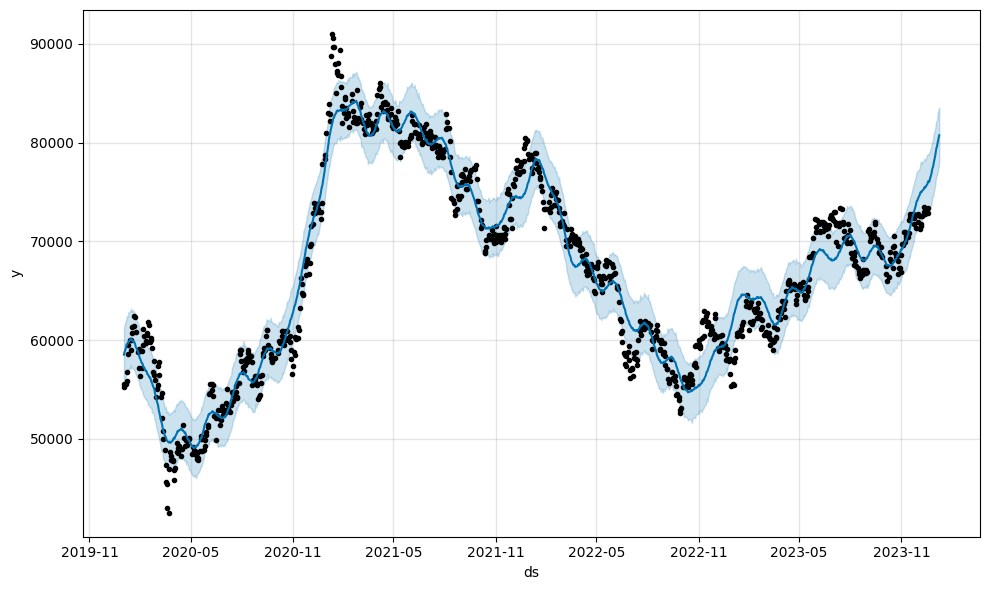

21:13:09 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 8540.938735754566
Mean Squared Error (MSE): 106882327.85565986


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


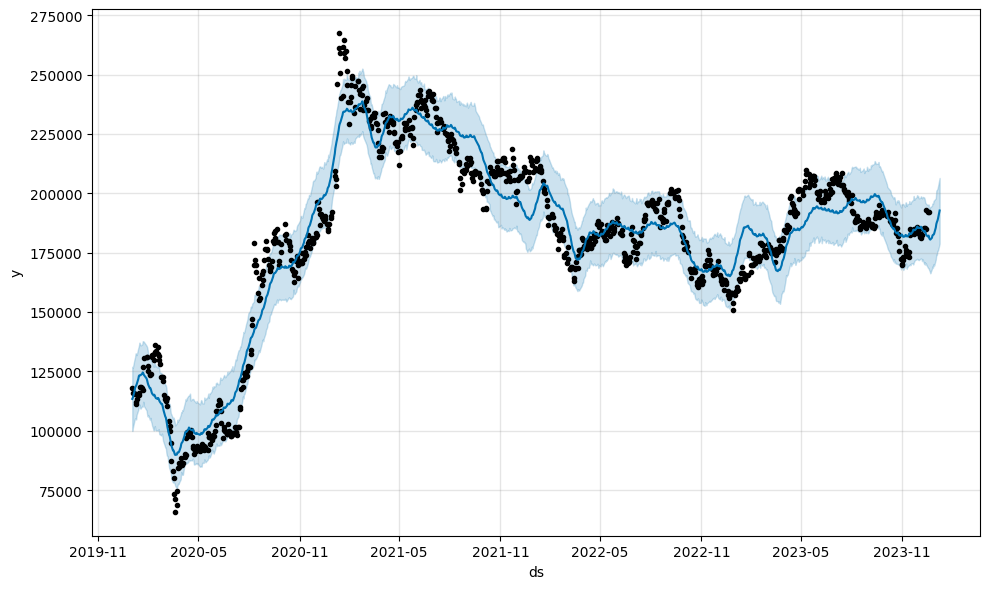

21:13:14 - cmdstanpy - INFO - Chain [1] start processing
21:13:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 37195.90141712821
Mean Squared Error (MSE): 2108586466.3597047


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


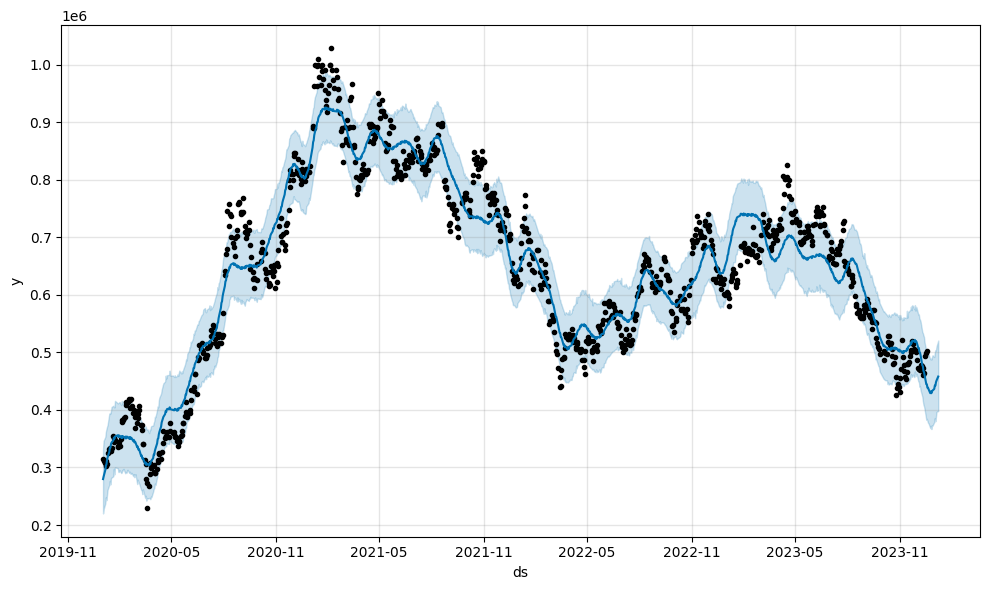

21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 25170.874641987535
Mean Squared Error (MSE): 1077715853.1084545


c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\dev\python\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


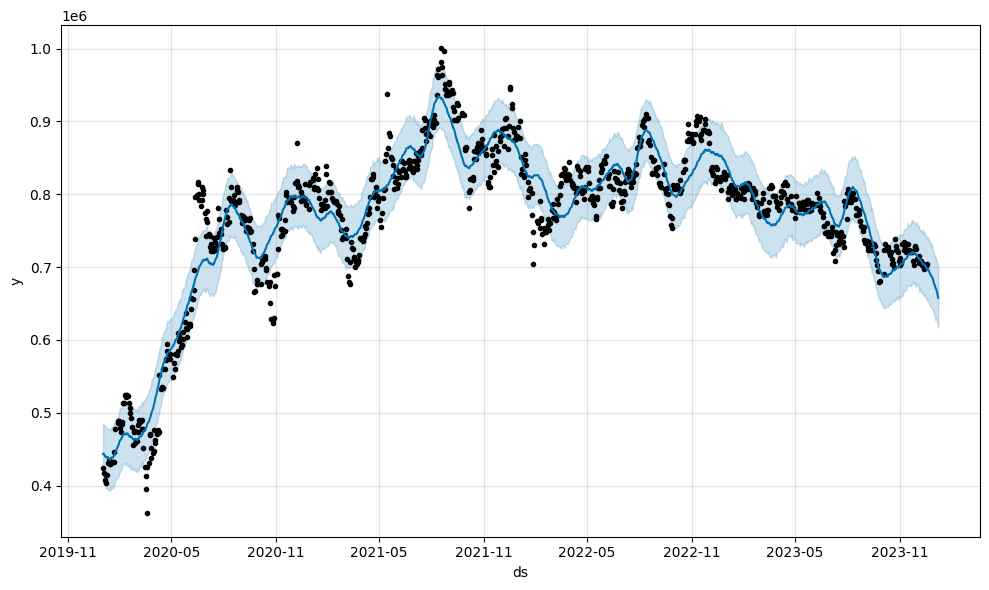

In [11]:
# 예측을 위한 주식 종목 리스트
stock_list = ["삼성전자", "현대차", "LG화학", "POSCO", "삼성바이오로직스"]

forecast_list = []

# 모든 주식 종목에 대한 예측 수행
for stock in stock_list:
    df_stock = get_stock_data(stock, year=2020)
    if df_stock is not None:
        scaled_data = preprocess_data(df_stock)

        # Train Prophet model
        model, forecast = train_prophet_model(df_stock, days_to_predict=14)

        # Plot forecast
        plot_prophet_forecast(model, forecast)

        # Save forecast to dataframe
        forecast_df = save_forecast_to_dataframe(df_stock, forecast, stock)
        forecast_list.append(forecast_df)

In [12]:
import pandas as pd

In [13]:
forecast_list2=forecast_list.copy()

In [14]:
forecast_list2

[          Date  Predicted_Close Stock
 981 2023-12-20     76000.165320  삼성전자
 982 2023-12-21     76026.715874  삼성전자
 983 2023-12-22     76248.011177  삼성전자
 984 2023-12-25     76844.209408  삼성전자
 985 2023-12-26     77193.531031  삼성전자
 986 2023-12-27     77426.288283  삼성전자
 987 2023-12-28     77563.211417  삼성전자
 988 2023-12-29     77889.506428  삼성전자
 989 2024-01-01     78746.335630  삼성전자
 990 2024-01-02     79157.868541  삼성전자
 991 2024-01-03     79437.798350  삼성전자
 992 2024-01-04     79605.646356  삼성전자
 993 2024-01-05     79945.724850  삼성전자
 994 2024-01-08     80737.187080  삼성전자,
           Date  Predicted_Close Stock
 981 2023-12-20    181223.149236   현대차
 982 2023-12-21    180713.968643   현대차
 983 2023-12-22    180518.480968   현대차
 984 2023-12-25    181262.188248   현대차
 985 2023-12-26    182235.209378   현대차
 986 2023-12-27    182518.758116   현대차
 987 2023-12-28    182596.049453   현대차
 988 2023-12-29    183003.002127   현대차
 989 2024-01-01    185551.152783   현대차
 990 2024-01-02    18709

In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,423058.986908,403172.809947,485546.042837,423058.986908,423058.986908,20619.420028,20619.420028,20619.420028,5177.127506,...,695.423969,695.423969,695.423969,13452.586676,13452.586676,13452.586676,0.0,0.0,0.0,443678.406936
1,2020-01-03,424535.395492,403335.382808,483600.786586,424535.395492,424535.395492,19489.014403,19489.014403,19489.014403,5177.127506,...,1574.826442,1574.826442,1574.826442,11442.778579,11442.778579,11442.778579,0.0,0.0,0.0,444024.409895
2,2020-01-06,428964.621243,397992.161248,482314.282291,428964.621243,428964.621243,10604.177382,10604.177382,10604.177382,5177.127506,...,-852.959304,-852.959304,-852.959304,4985.727304,4985.727304,4985.727304,0.0,0.0,0.0,439568.798625
3,2020-01-07,430441.029827,396219.191114,480680.618398,430441.029827,430441.029827,9596.063094,9596.063094,9596.063094,5177.127506,...,354.881956,354.881956,354.881956,2769.771755,2769.771755,2769.771755,0.0,0.0,0.0,440037.092920
4,2020-01-08,431917.438410,395858.202552,479517.467857,431917.438410,431917.438410,6559.132764,6559.132764,6559.132764,5177.127506,...,-477.895171,-477.895171,-477.895171,565.618553,565.618553,565.618553,0.0,0.0,0.0,438476.571174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,2024-01-02,656156.417439,633890.225071,714933.586558,656044.893964,656178.673561,18984.596138,18984.596138,18984.596138,5177.127506,...,354.881956,354.881956,354.881956,13452.586676,13452.586676,13452.586676,0.0,0.0,0.0,675141.013577
991,2024-01-03,655612.714591,626633.291595,714868.232240,655426.984574,655679.804573,16142.010913,16142.010913,16142.010913,5177.127506,...,-477.895171,-477.895171,-477.895171,11442.778579,11442.778579,11442.778579,0.0,0.0,0.0,671754.725504
992,2024-01-04,655069.011743,629444.227867,711534.143184,654819.462746,655188.655091,15219.518175,15219.518175,15219.518175,5177.127506,...,695.423969,695.423969,695.423969,9346.966700,9346.966700,9346.966700,0.0,0.0,0.0,670288.529919
993,2024-01-05,654525.308895,628924.847373,708506.803099,654211.416416,654686.106597,13938.622605,13938.622605,13938.622605,5177.127506,...,1574.826442,1574.826442,1574.826442,7186.668657,7186.668657,7186.668657,0.0,0.0,0.0,668463.931501


In [17]:
send_data = []
for forecast in forecast_list:
    # forecast['Stock']이 Series나 DataFrame 열일 경우 첫 번째 값을 문자열로 추출
    stock_name = forecast['Stock']
    if isinstance(stock_name, pd.Series) or isinstance(stock_name, pd.DataFrame):
        stock_name = stock_name.iloc[0]

    # df_krx DataFrame에서 해당 주식 이름에 맞는 'Code'를 찾음
    matched_code = df_krx.loc[df_krx['Name'] == stock_name, 'Code']
    
    # 해당하는 코드가 없으면 오류를 방지하기 위해 기본값 설정
    stock_code = matched_code.iloc[0] if not matched_code.empty else None

    if stock_code:
        today_date = datetime.now().strftime('%Y-%m-%d')

        # 예측 데이터 처리 및 DataFrame 생성
        data = {
            'code': stock_code,
            'name': stock_name,
            'date': today_date,
            'day1': int(forecast['Predicted_Close'].iloc[0]),
            'day2': int(forecast['Predicted_Close'].iloc[1]),
            'day3': int(forecast['Predicted_Close'].iloc[2]),
            'day4': int(forecast['Predicted_Close'].iloc[3]),
            'day5': int(forecast['Predicted_Close'].iloc[4]),
            'day6': int(forecast['Predicted_Close'].iloc[5]),
            'day7': int(forecast['Predicted_Close'].iloc[6]),
            'day8': int(forecast['Predicted_Close'].iloc[7]),
            'day9': int(forecast['Predicted_Close'].iloc[8]),
            'day10': int(forecast['Predicted_Close'].iloc[9])
        }
        send_data.append(data)


In [36]:
type(send_data[1]['code'])

str

In [19]:
conn = pymysql.connect(host='localhost', user='urstory', password='u1234', db='miniprojectdb', charset='utf8')

In [20]:
cur = conn.cursor()

In [ ]:
# 최초에 table 형성할때 한번만 실행하면 OK

sql= '''create table predict (
    id int not null AUTO_INCREMENT COMMENT '기본키',
    code varchar(30) not null COMMENT '주식 코드',
    name varchar(30) not null COMMENT '주식 이름',
    date DATE not null COMMENT '예측 일자',
    day1 int not null COMMENT '예측 종가',
    day2 int not null COMMENT '예측 종가',
    day3 int not null COMMENT '예측 종가',
    day4 int not null COMMENT '예측 종가',
    day5 int not null COMMENT '예측 종가',
    day6 int not null COMMENT '예측 종가',
    day7 int not null COMMENT '예측 종가',
    day8 int not null COMMENT '예측 종가',
    day9 int not null COMMENT '예측 종가',
    day10 int not null COMMENT '예측 종가',
	PRIMARY KEY(id),
    UNIQUE KEY(code, date)
);
'''
cur.execute(sql)

In [22]:
insert_sql = '''
INSERT INTO predict (code, name, date, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10)
VALUES (%s, %s, %s, %d, %d, %d, %d, %d, %d, %d, %d, %d, %d)
'''

for data in send_data:
    # 데이터 변환 및 삽입 로직
    values = [
        data['code'],
        data['name'],
        data['date'],  # 예측 일자
        data['day1'],
        data['day2'],
        data['day3'],
        data['day4'],
        data['day5'],
        data['day6'],
        data['day7'],
        data['day8'],
        data['day9'],
        data['day10']
    ]
    cur.executemany(insert_sql, values)

TypeError: not enough arguments for format string

In [23]:
# send_data= []
# for i in range(len(forecast_list)):
#     forecast_list2[i]['Predicted_Close']=(forecast_list[i]['Predicted_Close']/100).round()*100
#     forecast_list2[i]['Code'] = (df_krx['Code'].loc[df_krx['Name'] == (forecast_list[i]['Stock'].head(1).values[0])]).values[0]
#     data = pd.DataFrame([])
#     data['code']=forecast_list2[i]['Code'].head(1)
#     data['name']=forecast_list2[i]['Stock'].head(1)
#     data['date']=datetime()
#     data[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10']]=list(map(int,list(forecast_list2[i].head(10)['Predicted_Close'])))
#     data=data.reset_index(drop=True)
#     send_data.append(data)

k=0
for i in range(len(send_data)):
    sql = f'''INSERT INTO predict (code, name, day1, day2, day3, day4, day5, day6, day7, day8, day9, day10) 
VALUES ('{send_data[i]['code'][k]}','{send_data[i]['name'][k]}','{send_data[i]['date'][k]}', {send_data[i]['day1'][k]}, {send_data[i]['day2'][k]}, {send_data[i]['day3'][k]},{send_data[i]['day4'][k]}, {send_data[i]['day5'][k]}, {send_data[i]['day6'][k]}, {send_data[i]['day7'][k]}, {send_data[i]['day8'][k]}, {send_data[i]['day9'][k]}, {send_data[i]['day10'][k]});
          '''
    print(sql)
    cur.execute(sql)
    conn.commit()


TypeError: 'int' object is not subscriptable